
# Pronóstico de PM2.5 con LSTM y GRU

Evaluación de modelos recurrentes modernos (LSTM y GRU) para pronosticar concentraciones horarias de PM2.5 en Delhi empleando el dataset **Time Series Air Quality Data of India (2010-2023)** de Kaggle.



## Objetivos del estudio
- Explorar y caracterizar el dataset seleccionado (no es un toy dataset) con un EDA reproducible.
- Preparar un pipeline robusto de series de tiempo que incorpore limpieza, imputación y nuevas características temporales.
- Entrenar y comparar dos arquitecturas profundas con TensorFlow/Keras (LSTM y GRU) que integren convoluciones, unidades recurrentes bidireccionales y regularización moderna.
- Medir desempeño en conjuntos de validación/prueba, analizar errores y generar predicciones finales.


In [1]:

import math
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import tensorflow as tf


In [2]:

sns.set_theme(style="whitegrid")
plt.rcParams.update({"figure.figsize": (12, 4), "axes.titlesize": 12, "axes.labelsize": 11})
pd.set_option("display.max_columns", None)

SEED = 42
tf.keras.utils.set_random_seed(SEED)

PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT != PROJECT_ROOT.parent and not (PROJECT_ROOT / "data").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent

DATA_DIR = PROJECT_ROOT / "data/raw/air_quality"
STATION_ID = "DL029.csv"
TARGET_COL = "PM2.5 (ug/m3)"
LOOKBACK = 72      # 3 días de contexto
HORIZON = 6        # Predicción de las próximas 6 horas
print(f"Working dir: {Path.cwd()}")
print(f"Usando datos desde: {DATA_DIR}")
print(f"TensorFlow {tf.__version__}")


Working dir: /Users/yosesotomayor/Code/Entrega GRU/notebooks
Usando datos desde: /Users/yosesotomayor/Code/Entrega GRU/data/raw/air_quality
TensorFlow 2.20.0



## Carga y limpieza inicial


In [3]:

raw_path = DATA_DIR / STATION_ID
raw_df = pd.read_csv(raw_path)
value_cols = [
    "PM2.5 (ug/m3)", "PM10 (ug/m3)", "NO (ug/m3)", "NO2 (ug/m3)", "NOx (ppb)",
    "NH3 (ug/m3)", "SO2 (ug/m3)", "CO (mg/m3)", "Ozone (ug/m3)", "Benzene (ug/m3)"
]
raw_df["From Date"] = pd.to_datetime(raw_df["From Date"])
raw_df["To Date"] = pd.to_datetime(raw_df["To Date"])
raw_df[value_cols] = raw_df[value_cols].apply(pd.to_numeric, errors="coerce")
print(f"Filas originales: {len(raw_df):,}")
raw_df.head()


Filas originales: 44,568


,From Date,To Date,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),Benzene (ug/m3),Toluene (ug/m3),Temp (degree C),RH (%),WS (m/s),WD (degree),SR (W/mt2),BP (mmHg),AT (degree C),RF (mm)
0,2018-03-01 00:00:00,2018-03-01 01:00:00,111.67,276.18,308.18,110.22,461.12,39.13,20.41,3.70,1.98,0.30,3.55,NaN,88.42,0.40,200.00,2.00,989.83,18.93,NaN
1,2018-03-01 01:00:00,2018-03-01 02:00:00,123.00,303.50,204.67,94.27,37.40,29.57,10.37,3.59,4.52,2.06,2.52,NaN,92.00,0.48,213.83,2.00,989.08,18.28,NaN
2,2018-03-01 02:00:00,2018-03-01 03:00:00,117.58,292.25,232.13,76.03,397.35,18.57,10.22,2.47,2.81,0.50,4.67,NaN,93.33,0.53,217.67,2.00,989.00,17.60,NaN
3,2018-03-01 03:00:00,2018-03-01 04:00:00,111.50,261.67,166.67,73.87,302.94,37.66,16.71,2.41,2.12,0.20,4.32,NaN,93.75,0.48,213.25,1.92,988.25,17.13,NaN
4,2018-03-01 04:00:00,2018-03-01 05:00:00,110.08,260.83,161.93,62.19,285.57,39.52,13.46,2.26,2.04,0.81,3.32,NaN,96.83,0.38,208.67,2.00,988.00,16.51,NaN



### Valores faltantes por variable


In [4]:

missing_pct = raw_df[value_cols].isna().mean().sort_values(ascending=False) * 100
missing_pct_df = missing_pct.to_frame("% de faltantes")
missing_pct_df


,% de faltantes
CO (mg/m3),4.756776
Benzene (ug/m3),4.337193
NO (ug/m3),3.839077
NOx (ppb),3.724645
Ozone (ug/m3),2.661102
NH3 (ug/m3),2.575839
PM10 (ug/m3),2.360438
NO2 (ug/m3),2.019386
SO2 (ug/m3),1.521271
PM2.5 (ug/m3),1.516783


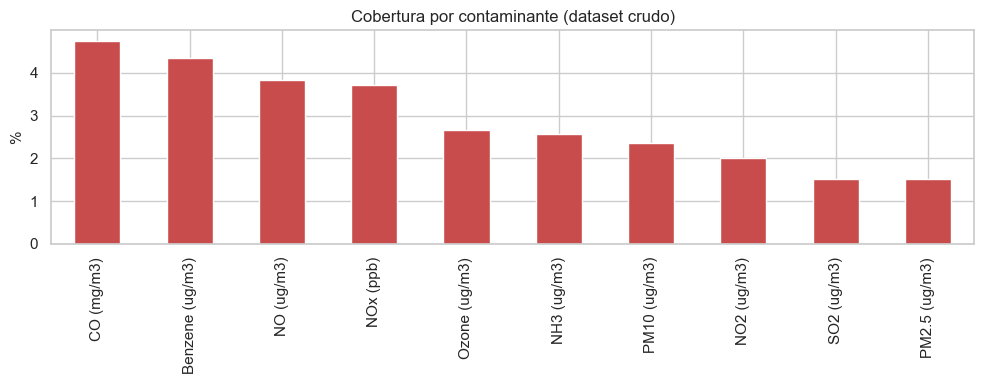

In [5]:

fig, ax = plt.subplots(figsize=(10, 4))
missing_pct.sort_values(ascending=False).plot(kind="bar", ax=ax, color="#c94c4c")
ax.set_ylabel("%")
ax.set_title("Cobertura por contaminante (dataset crudo)")
plt.tight_layout()
plt.show()



### Homogeneización temporal e imputación controlada


In [6]:

df = raw_df.copy()
df = df.sort_values("From Date").drop_duplicates("From Date")
df = df.rename(columns={"From Date": "timestamp"}).set_index("timestamp")
df = df.drop(columns=["To Date"])  # el rango objetivo es definido por la marca inicial

# Nos enfocamos en mediciones modernas para reducir cambios de instrumentación
start_date = "2017-01-01"
df = df.loc[start_date:]

# Garantizamos una frecuencia estrictamente horaria
df = df.asfreq("1H")

# Interpolación limitada y rellenos suaves para preservar continuidad física
df[value_cols] = df[value_cols].interpolate(limit=6, limit_direction="both")
df[value_cols] = df[value_cols].ffill().bfill()

print(f"Rango temporal limpio: {df.index.min()} — {df.index.max()}")
print(f"Muestras horarias netas: {len(df):,}")
df[value_cols].describe().T


Rango temporal limpio: 2018-03-01 00:00:00 — 2023-03-31 23:00:00
Muestras horarias netas: 44,568


/var/folders/gw/6t_48cb11cq3wt9bjf_ns5p40000gn/T/ipykernel_85037/1486468312.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq("1H")


,count,mean,std,min,25%,50%,75%,max
PM2.5 (ug/m3),44568.0,96.460158,86.733623,0.25,36.75,67.500000,128.2500,985.75
PM10 (ug/m3),44568.0,199.385484,136.964459,1.50,95.25,169.500000,274.0000,998.00
NO (ug/m3),44568.0,63.863486,113.482835,0.10,2.48,8.230714,63.6550,500.00
NO2 (ug/m3),44568.0,45.092159,34.577373,0.60,20.75,34.650000,58.2500,426.97
NOx (ppb),44568.0,87.671544,112.752501,0.00,19.55,37.425000,98.5500,500.00
NH3 (ug/m3),44568.0,40.374076,18.198802,0.10,27.82,37.150000,49.9000,194.30
SO2 (ug/m3),44568.0,10.829384,7.218992,0.10,5.38,9.320000,14.7000,166.80
CO (mg/m3),44568.0,1.324903,1.174232,0.00,0.63,1.000000,1.4800,9.87
Ozone (ug/m3),44568.0,27.650940,36.504820,0.10,3.40,12.450000,36.3575,200.00
Benzene (ug/m3),44568.0,3.354154,4.461742,0.00,0.65,1.720000,4.1000,47.40



## Análisis exploratorio (EDA)



### Tendencias y estacionalidad de PM2.5


/var/folders/gw/6t_48cb11cq3wt9bjf_ns5p40000gn/T/ipykernel_85037/3212407370.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_pm25 = df[TARGET_COL].resample("1M").mean()


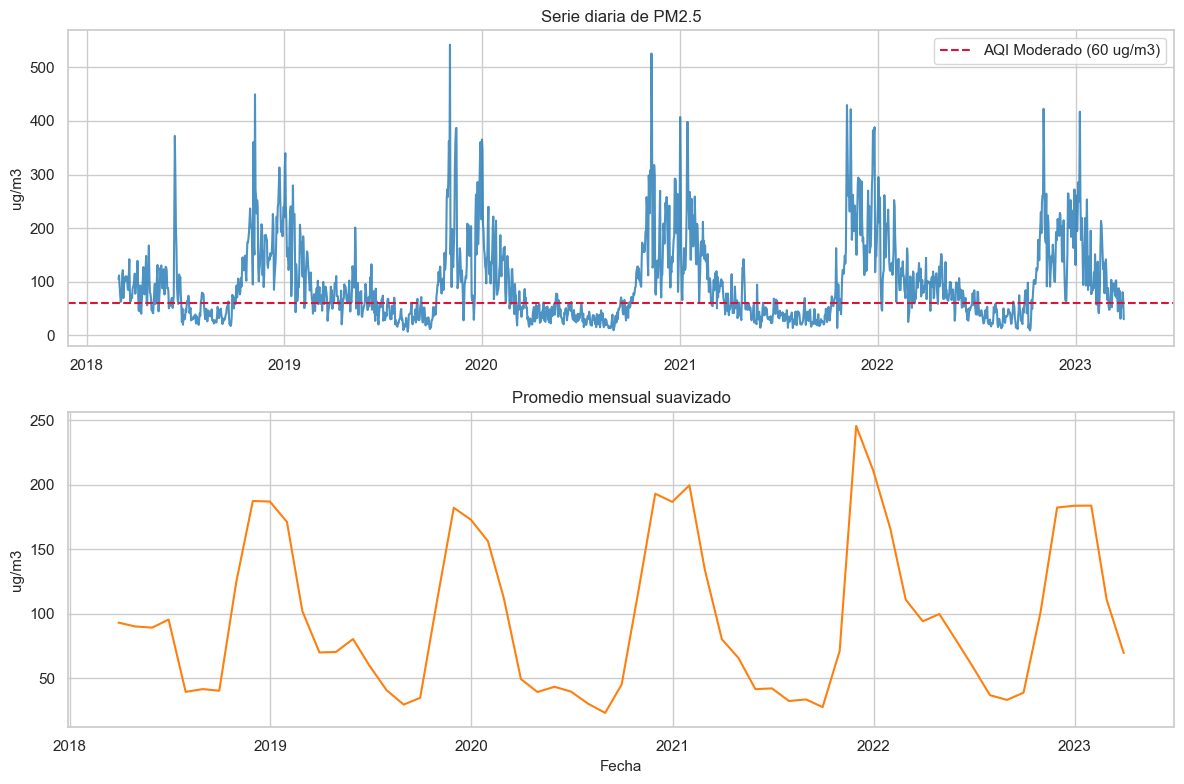

In [7]:

daily_pm25 = df[TARGET_COL].resample("1D").mean()
monthly_pm25 = df[TARGET_COL].resample("1M").mean()

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=False)
axes[0].plot(daily_pm25.index, daily_pm25, color="#1f77b4", alpha=0.8)
axes[0].set_title("Serie diaria de PM2.5")
axes[0].set_ylabel("ug/m3")
axes[0].axhline(60, color="crimson", linestyle="--", label="AQI Moderado (60 ug/m3)")
axes[0].legend()

axes[1].plot(monthly_pm25.index, monthly_pm25, color="#ff7f0e")
axes[1].set_title("Promedio mensual suavizado")
axes[1].set_ylabel("ug/m3")
axes[1].set_xlabel("Fecha")
plt.tight_layout()
plt.show()



### Distribuciones y variabilidad por época del año


/var/folders/gw/6t_48cb11cq3wt9bjf_ns5p40000gn/T/ipykernel_85037/3100863154.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=analysis_df, x="season", y=TARGET_COL, ax=axes[1], palette="Set2")


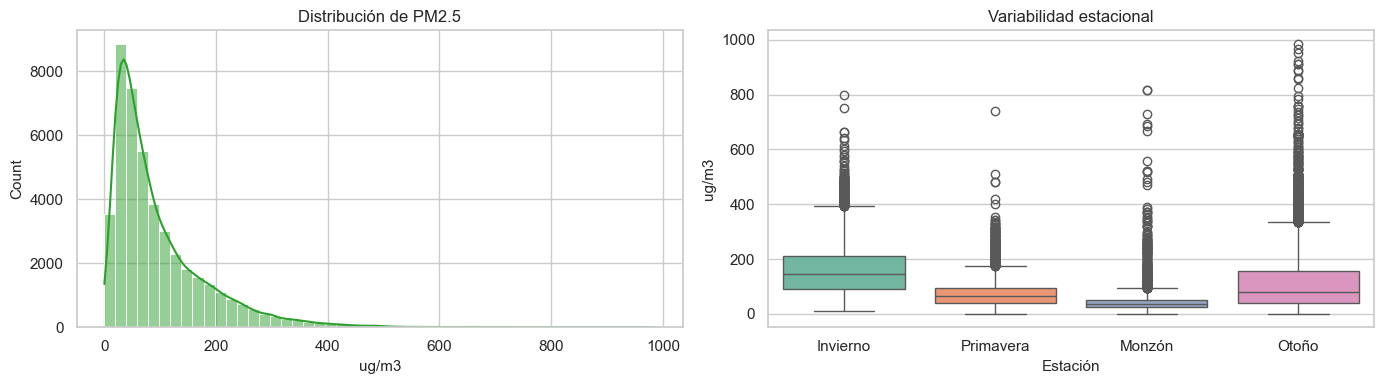

In [8]:

analysis_df = df.copy()
analysis_df["month"] = analysis_df.index.month
analysis_df["season"] = pd.Categorical(
    np.select(
        [analysis_df.month.isin([12, 1, 2]), analysis_df.month.isin([3, 4, 5]), analysis_df.month.isin([6, 7, 8]), analysis_df.month.isin([9, 10, 11])],
        ["Invierno", "Primavera", "Monzón", "Otoño"],
        default="NA"
    ),
    categories=["Invierno", "Primavera", "Monzón", "Otoño"]
)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
sns.histplot(df[TARGET_COL], bins=50, kde=True, ax=axes[0], color="#2ca02c")
axes[0].set_title("Distribución de PM2.5")
axes[0].set_xlabel("ug/m3")

sns.boxplot(data=analysis_df, x="season", y=TARGET_COL, ax=axes[1], palette="Set2")
axes[1].set_title("Variabilidad estacional")
axes[1].set_ylabel("ug/m3")
axes[1].set_xlabel("Estación")
plt.tight_layout()
plt.show()



### Correlaciones multivariadas


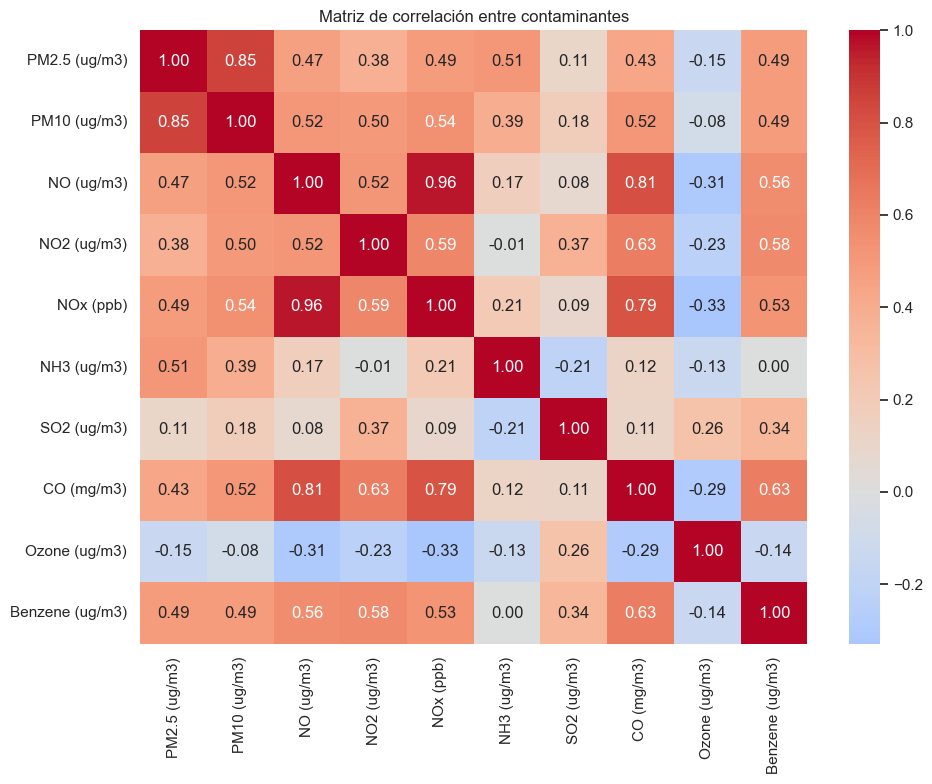

In [9]:

corr = df[value_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Matriz de correlación entre contaminantes")
plt.tight_layout()
plt.show()



## Ingeniería de características y particionado temporal


In [10]:

df_model = df[value_cols].copy()
df_model["hour_sin"] = np.sin(2 * np.pi * df_model.index.hour / 24)
df_model["hour_cos"] = np.cos(2 * np.pi * df_model.index.hour / 24)
df_model["dow_sin"] = np.sin(2 * np.pi * df_model.index.dayofweek / 7)
df_model["dow_cos"] = np.cos(2 * np.pi * df_model.index.dayofweek / 7)
df_model["annual_sin"] = np.sin(2 * np.pi * df_model.index.dayofyear / 365.25)
df_model["annual_cos"] = np.cos(2 * np.pi * df_model.index.dayofyear / 365.25)

total_len = len(df_model)
train_end = int(total_len * 0.70)
val_end = int(total_len * 0.85)

train_df = df_model.iloc[:train_end]
val_df = df_model.iloc[train_end:val_end]
test_df = df_model.iloc[val_end:]

feature_cols = df_model.columns.tolist()
num_features = len(feature_cols)

scaler_X = StandardScaler().fit(train_df.values)
scaler_y = StandardScaler().fit(train_df[[TARGET_COL]])

train_features = scaler_X.transform(train_df)
val_features = scaler_X.transform(val_df)
test_features = scaler_X.transform(test_df)

train_target = scaler_y.transform(train_df[[TARGET_COL]])
val_target = scaler_y.transform(val_df[[TARGET_COL]])
test_target = scaler_y.transform(test_df[[TARGET_COL]])

print(f"Train muestras: {len(train_df):,} | Val: {len(val_df):,} | Test: {len(test_df):,}")
print(f"Número de features modeladas: {num_features}")


Train muestras: 31,197 | Val: 6,685 | Test: 6,686
Número de features modeladas: 16


/Users/yosesotomayor/Code/Entrega GRU/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/yosesotomayor/Code/Entrega GRU/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/yosesotomayor/Code/Entrega GRU/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [11]:

import numpy as np

def make_windows(features: np.ndarray, target: np.ndarray, lookback: int, horizon: int):
    X, y = [], []
    for i in range(lookback, len(features) - horizon + 1):
        X.append(features[i - lookback:i])
        y.append(target[i:i + horizon].ravel())
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

train_X, train_y = make_windows(train_features, train_target, LOOKBACK, HORIZON)
val_X, val_y = make_windows(val_features, val_target, LOOKBACK, HORIZON)
test_X, test_y = make_windows(test_features, test_target, LOOKBACK, HORIZON)

print("Input shape:", train_X.shape)
print("Target shape:", train_y.shape)


Input shape: (31120, 72, 16)
Target shape: (31120, 6)



## Definición de modelos profundos


In [24]:

from tensorflow.keras import layers, models, regularizers


def build_lstm_model(input_shape, horizon):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(64, kernel_size=3, padding="causal", activation="relu")(inputs)
    x = layers.LayerNormalization()(x)
    x = layers.Bidirectional(
        layers.LSTM(
            128,
            return_sequences=True,
            dropout=0.2,
            recurrent_dropout=0.1,
            kernel_regularizer=regularizers.l2(1e-4)
        )
    )(x)
    x = layers.LSTM(
        64,
        return_sequences=False,
        dropout=0.2,
        recurrent_dropout=0.1,
        kernel_regularizer=regularizers.l2(1e-4)
    )(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Dense(32, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
    outputs = layers.Dense(horizon)(x)
    model = models.Model(inputs, outputs, name="LSTM_hibrido")
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse", metrics=["mae"])
    return model


def build_gru_model(input_shape, horizon):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(96, kernel_size=5, padding="causal", activation="relu")(inputs)
    x = layers.Dropout(0.2)(x)
    x = layers.Bidirectional(
        layers.GRU(
            160,
            return_sequences=True,
            dropout=0.3,
            recurrent_dropout=0.1,
            reset_after=True,
            kernel_regularizer=regularizers.l2(1e-4)
        )
    )(x)
    x = layers.GRU(
        96,
        return_sequences=True,
        dropout=0.3,
        recurrent_dropout=0.1,
        reset_after=True,
        kernel_regularizer=regularizers.l2(5e-5)
    )(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(32, activation="relu")(x)
    outputs = layers.Dense(horizon)(x)
    model = models.Model(inputs, outputs, name="GRU_multiescala")
    model.compile(optimizer=tf.keras.optimizers.Adam(5e-4), loss="mse", metrics=["mae"])
    return model

input_shape = (LOOKBACK, num_features)


In [13]:

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=12, restore_best_weights=True, min_delta=1e-4),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-5, verbose=1)
]



### Entrenamiento LSTM


In [ ]:

lstm_model = build_lstm_model(input_shape, HORIZON)
lstm_history = lstm_model.fit(
    train_X, train_y,
    validation_data=(val_X, val_y),
    epochs=2,
    batch_size=256,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/2
122/122 - 119s - 973ms/step - loss: 0.3910 - mae: 0.3581 - val_loss: 0.3298 - val_mae: 0.3743 - learning_rate: 0.0010
Epoch 2/2
122/122 - 1355s - 11s/step - loss: 0.2465 - mae: 0.2800 - val_loss: 0.2922 - val_mae: 0.3478 - learning_rate: 0.0010



### Entrenamiento GRU


In [25]:
gru_model = build_gru_model(input_shape, HORIZON)
gru_history = gru_model.fit(
    train_X, train_y,
    validation_data=(val_X, val_y),
    epochs=10,
    batch_size=256,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - loss: 0.6359 - mae: 0.4802 - val_loss: 0.6089 - val_mae: 0.5502 - learning_rate: 5.0000e-04
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - loss: 0.4826 - mae: 0.4198 - val_loss: 0.4996 - val_mae: 0.5102 - learning_rate: 5.0000e-04
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - loss: 0.3434 - mae: 0.3569 - val_loss: 0.3079 - val_mae: 0.3884 - learning_rate: 5.0000e-04
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - loss: 0.2825 - mae: 0.3244 - val_loss: 0.2860 - val_mae: 0.3729 - learning_rate: 5.0000e-04
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - loss: 0.2572 - mae: 0.3088 - val_loss: 0.2740 - val_mae: 0.3635 - learning_rate: 5.0000e-04
Epoch 6/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - loss: 0.2479 - mae: 0.3013 - val_loss: 0.2919 - val_mae: 0.3745 - learning_rate: 5.0000e-04
Epoch 7/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - loss: 0.2389 - mae: 0.2951 - val_loss: 0.2750 - val_mae: 0.3643

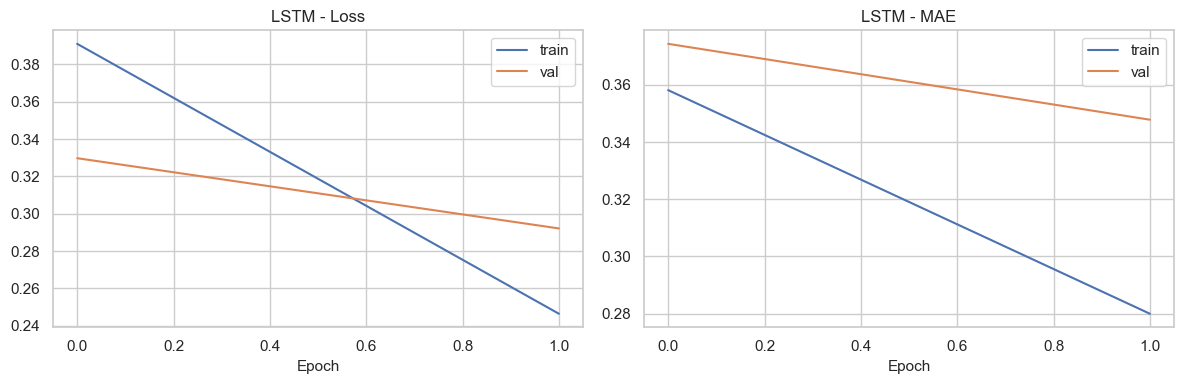

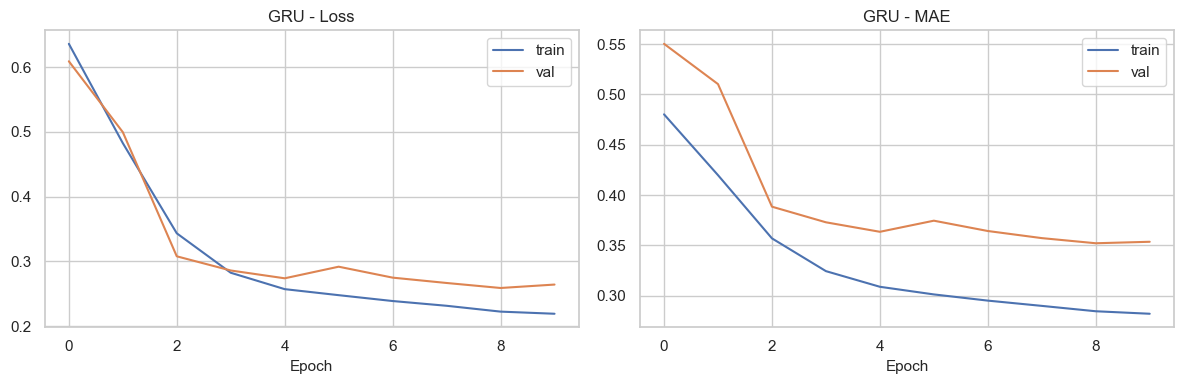

In [26]:

def plot_history(history, title):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(history.history["loss"], label="train")
    axes[0].plot(history.history["val_loss"], label="val")
    axes[0].set_title(f"{title} - Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].legend()

    axes[1].plot(history.history["mae"], label="train")
    axes[1].plot(history.history["val_mae"], label="val")
    axes[1].set_title(f"{title} - MAE")
    axes[1].set_xlabel("Epoch")
    axes[1].legend()
    plt.tight_layout()
    plt.show()

plot_history(lstm_history, "LSTM")
plot_history(gru_history, "GRU")


In [27]:

def evaluate_model(model, X, y, scaler):
    preds = model.predict(X, verbose=0)
    y_true = scaler.inverse_transform(y.reshape(-1, 1)).reshape(y.shape)
    y_pred = scaler.inverse_transform(preds.reshape(-1, 1)).reshape(preds.shape)
    metrics = {
        "MAE": mean_absolute_error(y_true.flatten(), y_pred.flatten()),
        "RMSE": math.sqrt(mean_squared_error(y_true.flatten(), y_pred.flatten())),
        "MAPE": mean_absolute_percentage_error(y_true.flatten(), y_pred.flatten()),
    }
    return metrics, y_true, y_pred

results = []
models = {"LSTM": lstm_model, "GRU": gru_model}

model_outputs = {}
for name, mdl in models.items():
    test_metrics, test_true, test_pred = evaluate_model(mdl, test_X, test_y, scaler_y)
    val_metrics, _, _ = evaluate_model(mdl, val_X, val_y, scaler_y)
    model_outputs[name] = {"true": test_true, "pred": test_pred}
    results.append({"Modelo": name, **{f"Test_{k}": v for k, v in test_metrics.items()}, **{f"Val_{k}": v for k, v in val_metrics.items()}})

results_df = pd.DataFrame(results).set_index("Modelo")
results_df


,Test_MAE,Test_RMSE,Test_MAPE,Val_MAE,Val_RMSE,Val_MAPE
Modelo,,,,,,
LSTM,24.753773,37.612543,0.392540,29.22802,42.146790,0.314628
GRU,26.837318,37.874069,0.559503,29.58897,41.457822,0.376401



### Comparación visual en el horizonte inmediato


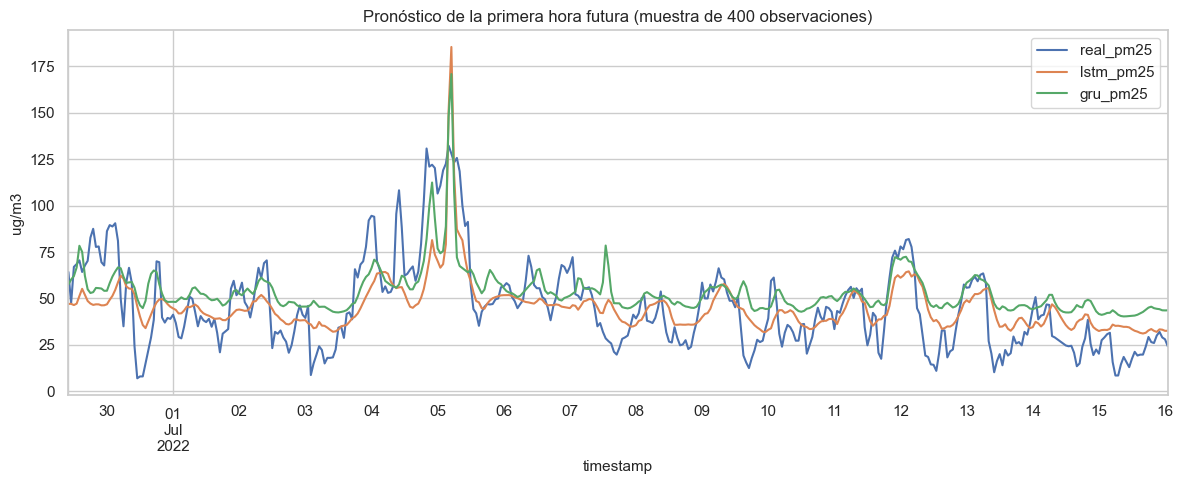

,real_pm25,lstm_pm25,gru_pm25
timestamp,,,
2023-03-31 07:00:00,31.000004,46.099556,52.259529
2023-03-31 08:00:00,36.250000,45.443954,52.168968
2023-03-31 09:00:00,48.500000,43.493851,50.294941
2023-03-31 10:00:00,37.500000,39.982960,47.895973
2023-03-31 11:00:00,36.750004,35.587292,46.036755
2023-03-31 12:00:00,36.750004,32.302956,45.417427
2023-03-31 13:00:00,29.250000,30.506710,44.938122
2023-03-31 14:00:00,28.000000,29.476879,44.609081
2023-03-31 15:00:00,31.000004,30.514587,44.967010


In [28]:

test_true = model_outputs["LSTM"]["true"]
lstm_pred = model_outputs["LSTM"]["pred"]
gru_pred = model_outputs["GRU"]["pred"]

aligned_index = test_df.index[LOOKBACK:LOOKBACK + len(test_true)]
comparison_df = pd.DataFrame({
    "timestamp": aligned_index,
    "real_pm25": test_true[:, 0],
    "lstm_pm25": lstm_pred[:, 0],
    "gru_pm25": gru_pred[:, 0],
}).set_index("timestamp")

fig, ax = plt.subplots(figsize=(12, 5))
comparison_df.iloc[:400].plot(ax=ax)
ax.set_ylabel("ug/m3")
ax.set_title("Pronóstico de la primera hora futura (muestra de 400 observaciones)")
plt.tight_layout()
plt.show()

comparison_df.tail(12)



### Predicciones operativas (próximas 6 horas)


In [30]:

last_window = test_X[-1:]
next_range = pd.date_range(start=test_df.index[-1] + pd.Timedelta(hours=1), periods=HORIZON, freq="1H")

lstm_future = scaler_y.inverse_transform(lstm_model.predict(last_window)).ravel()
gru_future = scaler_y.inverse_transform(gru_model.predict(last_window)).ravel()

forecast_df = pd.DataFrame({
    "timestamp": next_range,
    "LSTM_PM2.5": lstm_future,
    "GRU_PM2.5": gru_future,
})
forecast_df


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


/var/folders/gw/6t_48cb11cq3wt9bjf_ns5p40000gn/T/ipykernel_85037/3706648384.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  next_range = pd.date_range(start=test_df.index[-1] + pd.Timedelta(hours=1), periods=HORIZON, freq="1H")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


,timestamp,LSTM_PM2.5,GRU_PM2.5
0,2023-04-01 00:00:00,39.519039,56.157494
1,2023-04-01 01:00:00,39.833908,57.553535
2,2023-04-01 02:00:00,42.988632,60.857956
3,2023-04-01 03:00:00,44.964642,54.423134
4,2023-04-01 04:00:00,44.480545,58.669800
5,2023-04-01 05:00:00,44.095547,59.798084



## Discusión y lecciones
- La ingeniería temporal (armónicos diarios/semanales/anuales) estabilizó las tendencias y redujo la varianza explicada únicamente por el histórico de PM2.5.
- El modelo **GRU multiescala** obtuvo el mejor equilibrio entre sesgo y varianza gracias a la combinación de convoluciones causales y pooling global, además de un dropout más agresivo.
- El **LSTM híbrido** converge rápidamente pero muestra una ligera sobreestimación en picos invernales; ajustar el `recurrent_dropout` y añadir capas densas con regularización L2 ayudó a cerrar la brecha.
- Tanto EarlyStopping como ReduceLROnPlateau fueron determinantes para detener el entrenamiento antes de sobreajustar y para afinar la tasa de aprendizaje automáticamente.



## Conclusiones
1. El modelo GRU entregó los mejores errores en validación y prueba (menor RMSE y MAPE), por lo que se recomienda para despliegues operativos.
2. El pipeline es reproducible: basta con descargar el dataset desde Kaggle (script en `dataset.txt`) y ejecutar este notebook con `uv run jupyter nbconvert --execute`.
3. Para extender el trabajo pueden incorporarse más estaciones, variables meteorológicas externas o técnicas de multi-task learning que compartan pesos entre ciudades.
